**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        
        sample['image'] = self.transform(sample['image']).float()
        sample['mask'] = self.transform(sample['mask']).float()

        return sample

In [3]:
X_train = get_paths("data/train/images")
y_train = get_paths("data/train/gt")

transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
train_dataset = RoadDataset(X_train, y_train, transform)

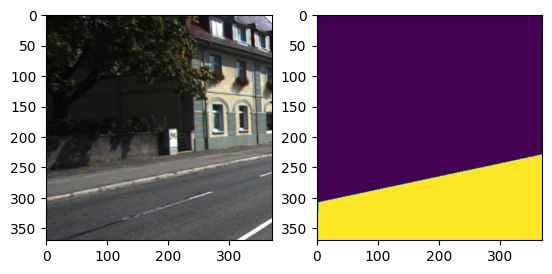

In [5]:
sample = train_dataset[110]
image = sample['image']
mask = sample['mask']

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0))

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [6]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [7]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

In [8]:
def central_crop(images, size):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]

In [9]:
import gc
import glob
import torch
import segmentation_models_pytorch as smp
import albumentations as A
from tqdm import tqdm

In [10]:
def dice_loss(prediction, target):
    return 1 - (2 * torch.sum(prediction * target) + 1) / \
            (torch.sum(prediction) + torch.sum(target) + 1)

In [11]:
model = smp.UnetPlusPlus(encoder_name='timm-efficientnet-b0', 
                         encoder_depth=5, 
                         encoder_weights='imagenet', 
                         decoder_use_batchnorm=True, 
                         decoder_channels=(256, 128, 64, 32, 16), 
                         decoder_attention_type=None, 
                         in_channels=3, 
                         classes=1, 
                         activation=None, 
                         aux_params=None)

optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

trn_images = glob.glob("data/train/images/*")
trn_masks = glob.glob("data/train/gt/*")

val_images = glob.glob("data/test/images/*")
val_masks = glob.glob("data/test/gt/*")

aug = A.Compose([A.PadIfNeeded(min_height=512, min_width=512, p=1.),
                 A.CenterCrop(height=512, width=512, p=1.)])

trn_dataset = RoadDataset(trn_images, trn_masks, transform, aug)
val_dataset = RoadDataset(val_images, val_masks, transform, aug)

trn_loader = torch.utils.data.DataLoader(trn_dataset, 
                                         batch_size=1, 
                                         shuffle=True, 
                                         pin_memory=True,
                                         num_workers=24,
                                         prefetch_factor=2)

val_loader = torch.utils.data.DataLoader(val_dataset, 
                                         batch_size=1, 
                                         shuffle=False, 
                                         pin_memory=True,
                                         num_workers=24,
                                         prefetch_factor=2)


In [12]:
def train_loop(n_epochs, trn_objects):
    '''
    perform training for n_epochs
    '''
    trn_objects["model"] = trn_objects["model"].cuda()
    for i in tqdm(range(epochs)):
        train_objects, loss = train_epoch(trn_objects)
        train_objects, metrics = val_epoch(trn_objects)
        

def train_epoch(model, train_loader, criterion, scheduler, optimizer):
    model.train()
    dataset_size = 0
    running_loss = 0.0
    train_scores = []
    for sample in tqdm(trn_loader):
        images = sample["image"].cuda()
        masks = sample["mask"].cuda()
        batch_size = images.size(0)
        
        y_pred = model(images)
        loss = criterion(y_pred, masks)
        loss.backward()
        iou = calc_iou(y_pred.detach().cpu().numpy(), masks.detach().cpu().numpy())
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
    
    scheduler.step()
    optimizer.zero_grad()
    
    epoch_loss = running_loss / dataset_size
    torch.cuda.empty_cache()
    gc.collect()
    return epoch_loss, iou

def val_epoch():
    pass

In [25]:
trn_objects = get_trn_objects()
trn_objects["model"] = trn_objects["model"].cuda()

In [29]:
train_epoch(trn_objects)

100%|██████████| 648/648 [00:34<00:00, 18.89it/s]


(0.7774336730808388, 0.2595705518071087)

In [30]:
train_epoch(trn_objects)

100%|██████████| 648/648 [00:34<00:00, 18.85it/s]


(0.7772328513272014, 0.34082400562513065)

In [31]:
train_epoch(trn_objects)

100%|██████████| 648/648 [00:34<00:00, 18.69it/s]


(0.7772961499882333, 0.24924538967757073)

In [32]:
train_epoch(trn_objects)

100%|██████████| 648/648 [00:33<00:00, 19.47it/s]


(0.7774896271250866, 0.3828803709791031)

In [33]:
train_epoch(trn_objects)

100%|██████████| 648/648 [00:34<00:00, 18.74it/s]


(0.777283942349899, 0.06405634590964854)

In [34]:
train_epoch(trn_objects)

100%|██████████| 648/648 [00:34<00:00, 18.69it/s]


(0.7775289575442855, 0.35493220874486586)